# 04. PyTorch Custom Datasets Exercises Template

Welcome to the 04. PyTorch Custom Datasets exercise template.

The best way to practice PyTorch code is to write more PyTorch code.

So read the original notebook and try to complete the exercises by writing code where it's required.

Feel free to reference the original resources whenever you need but should practice writing all of the code yourself.

## Resources

1. These exercises/solutions are based on [notebook 04 of the Learn PyTorch for Deep Learning course](https://www.learnpytorch.io/04_pytorch_custom_datasets/).
2. See a live [walkthrough of the solutions (errors and all) on YouTube](https://youtu.be/vsFMF9wqWx0).
3. See [other solutions on the course GitHub](https://github.com/mrdbourke/pytorch-deep-learning/tree/main/extras/solutions).

In [33]:
# Check for GPU
!nvidia-smi

Wed Aug 20 17:22:05 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   73C    P0             30W /   70W |     846MiB /  15360MiB |     12%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [34]:
# Import torch
import torch
from torch import nn

# Exercises require PyTorch > 1.10.0
print(torch.__version__)

# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

2.8.0+cu126


'cuda'

## 1. Our models are underperforming (not fitting the data well). What are 3 methods for preventing underfitting? Write them down and explain each with a sentence.

1. add layer/hidden units: so the model can learn more complex pattern on the data
2. tweaking the learning rate
3. train the model more

## 2. Recreate the data loading functions we built in [sections 1, 2, 3 and 4 of notebook 04](https://www.learnpytorch.io/04_pytorch_custom_datasets/). You should have train and test `DataLoader`'s ready to use.

In [35]:
# 1. Get data
import requests
import zipfile
from pathlib import Path

# Set up path for data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder does not exist, download it and prepare it
if image_path.is_dir():
  print(f"{image_path} directory already exists")

else:
  print(f"Did not find {image_path}, creating one...")
  image_path.mkdir(parents=True, exist_ok=True)

# Downloading pizza,steak,sushi data
with open(data_path / "pizza_steak_sushi.zip","wb") as f:
  request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
  print("Downloading pizza,steak,sushi data")
  f.write(request.content)

#unzif the data
with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip","r") as zip_ref:
  print("unziping the data")
  zip_ref.extractall(image_path)

# remove the zif file
import os
os.remove(data_path / "pizza_steak_sushi.zip")


data/pizza_steak_sushi directory already exists
unziping the data


In [36]:
# 2. Become one with the data
import os
def walk_through_dir(dir_path):
  """Walks through dir_path returning file counts of its contents."""
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [37]:
image_path

PosixPath('data/pizza_steak_sushi')

In [38]:
# Setup train and testing paths
train_dir = image_path /"train"
test_dir = image_path /"test"

walk_through_dir(train_dir)
walk_through_dir(test_dir)


There are 3 directories and 0 images in 'data/pizza_steak_sushi/train'.
There are 0 directories and 78 images in 'data/pizza_steak_sushi/train/pizza'.
There are 0 directories and 75 images in 'data/pizza_steak_sushi/train/steak'.
There are 0 directories and 72 images in 'data/pizza_steak_sushi/train/sushi'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/test'.
There are 0 directories and 25 images in 'data/pizza_steak_sushi/test/pizza'.
There are 0 directories and 19 images in 'data/pizza_steak_sushi/test/steak'.
There are 0 directories and 31 images in 'data/pizza_steak_sushi/test/sushi'.


steak


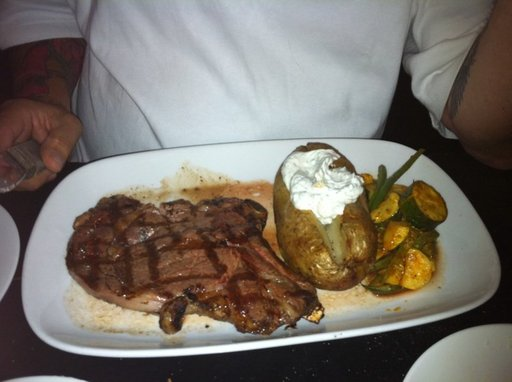

In [39]:
# Visualize an image
import random
from PIL import Image

# Get all image path
image_path_list = list(image_path.glob("*/*/*.jpg"))

# Pick a random image path
random_image_path = random.choice(image_path_list)

# Get image class from path name
image_class = random_image_path.parent.stem

# Open image
img = Image.open(random_image_path)

print(image_class)
img

In [40]:
image_class,random_image_path

('steak', PosixPath('data/pizza_steak_sushi/train/steak/100135.jpg'))

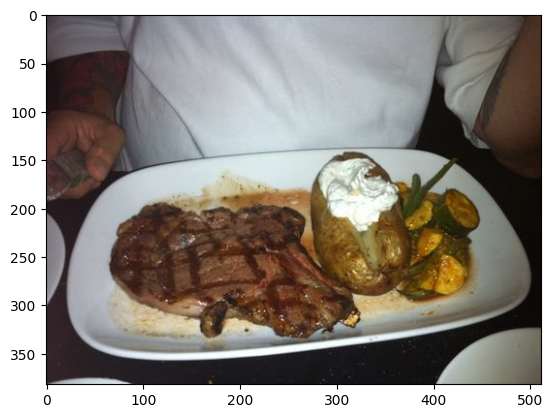

In [41]:
# Do the image visualization with matplotlib
import numpy as np
import matplotlib.pyplot as plt

# Turn the image into an array
img_as_array = np.asarray(img)

# plot the image with matplotlib
plt.imshow(img_as_array)

We've got some images in our folders.

Now we need to make them compatible with PyTorch by:
1. Transform the data into tensors.
2. Turn the tensor data into a `torch.utils.data.Dataset` and later a `torch.utils.data.DataLoader`.

In [42]:
# 3.1 Transforming data with torchvision.transforms
import torch
from torch.utils.data import DataLoader
from torchvision import datasets,transforms

In [43]:
# Write transform for turning images into tensors
data_transform = transforms.Compose([
    # Resize the image to 224 x 224
    transforms.Resize(size=(224,224)),
    # Flip the images randomly on the horizontal
    transforms.RandomHorizontalFlip(p=0.5),
    # Turn image to tensor
    transforms.ToTensor()
])

In [44]:
data_transform(img)


tensor([[[0.2471, 0.2588, 0.2824,  ..., 0.2745, 0.2784, 0.2824],
         [0.2549, 0.2706, 0.2824,  ..., 0.2824, 0.2902, 0.2941],
         [0.2588, 0.2784, 0.2902,  ..., 0.2824, 0.2902, 0.2980],
         ...,
         [0.1804, 0.1804, 0.1843,  ..., 0.3725, 0.3725, 0.3647],
         [0.1882, 0.2000, 0.2353,  ..., 0.3686, 0.3686, 0.3608],
         [0.2549, 0.3412, 0.4431,  ..., 0.3647, 0.3647, 0.3608]],

        [[0.2039, 0.2157, 0.2392,  ..., 0.1843, 0.1765, 0.1765],
         [0.2118, 0.2275, 0.2392,  ..., 0.1922, 0.1882, 0.1843],
         [0.2157, 0.2353, 0.2471,  ..., 0.1882, 0.1882, 0.1882],
         ...,
         [0.1333, 0.1412, 0.1412,  ..., 0.3373, 0.3333, 0.3255],
         [0.1451, 0.1608, 0.2000,  ..., 0.3333, 0.3333, 0.3255],
         [0.2118, 0.3020, 0.4118,  ..., 0.3294, 0.3294, 0.3176]],

        [[0.2196, 0.2314, 0.2549,  ..., 0.1333, 0.1255, 0.1255],
         [0.2275, 0.2431, 0.2549,  ..., 0.1412, 0.1373, 0.1373],
         [0.2314, 0.2510, 0.2667,  ..., 0.1412, 0.1412, 0.

In [45]:
# Write a function to plot transformed images
def plot_transformed_images(image_paths,transform, n=3, seed=42):
  random.seed(seed)
  random_image_paths = random.sample(image_paths,k=n)
  for image_path in random_image_paths:
    with Image.open(image_path) as f:
      fig,ax = plt.subplots(1,2)
      ax[0].imshow(f)
      ax[0].set_title(f"Original \nSize: {f.size}")
      ax[0].axis("off")

      # Transform and plot image
      transformed_image = transform(f).permute(1,2,0)
      ax[1].imshow(transformed_image)
      ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
      ax[1].axis("off")

      fig.suptitle(f"Class: {image_path.parent.stem}",fontsize=16)

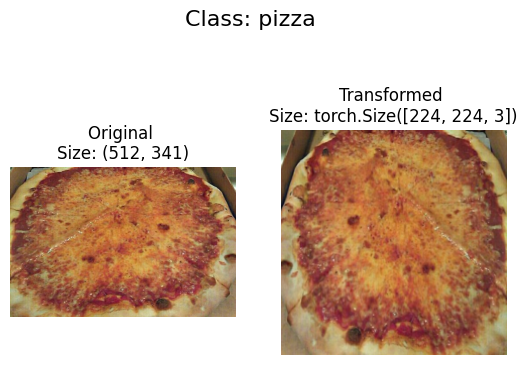

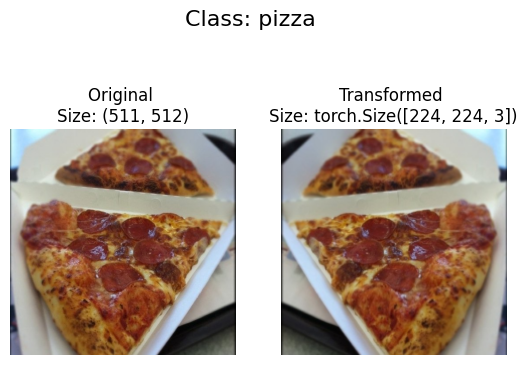

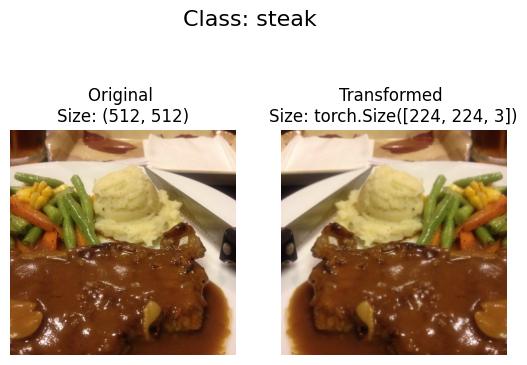

In [14]:
plot_transformed_images(image_path_list,data_transform)

### Load image data using `ImageFolder`

In [15]:
# Use ImageFolder to create dataset(s)
train_data=datasets.ImageFolder(root=train_dir,
                                transform=data_transform,
                                target_transform=None)
test_data=datasets.ImageFolder(root=test_dir,
                               transform=data_transform)

train_data,test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [16]:
# Get class names as a list
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [17]:
# Can also get class names as a dict
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [18]:
# Check the lengths of each dataset
len(train_data), len(test_data)

(225, 75)

In [19]:
# Turn train and test Datasets into DataLoaders
import os
from torch.utils.data import DataLoader

BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              num_workers=NUM_WORKERS,
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             num_workers=NUM_WORKERS,
                             shuffle=False)
train_dataloader,test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7c6d46303020>,
 <torch.utils.data.dataloader.DataLoader at 0x7c6d46155af0>)

In [20]:
# How many batches of images are in our data loaders?
img,label = next(iter(train_dataloader))
img.shape,label.shape

(torch.Size([32, 3, 224, 224]), torch.Size([32]))

## 3. Recreate `model_0` we built in section 7 of notebook 04.

In [21]:
class TinnyVGG(nn.Module):
  def __init__(self,
               input_shape: int,
               hidden_units: int,
               output_shape: int) -> None:
    super().__init__()
    self.conv_block1 = nn.Sequential(
        nn.Conv2d(
            in_channels=input_shape,
            out_channels=hidden_units,
            kernel_size=3,
            stride=1,
            padding=1
        ),
        nn.ReLU(),
        nn.Conv2d(
            in_channels=hidden_units,
            out_channels=hidden_units,
            kernel_size=3,
            stride=1,
            padding=1
        ),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                      stride=2)
    )
    self.conv_block2 = nn.Sequential(
        nn.Conv2d(
            in_channels=hidden_units,
            out_channels=hidden_units,
            kernel_size=3,
            stride=1,
            padding=1
        ),
        nn.ReLU(),
        nn.Conv2d(
            in_channels=hidden_units,
            out_channels=hidden_units,
            kernel_size=3,
            stride=1,
            padding=1
        ),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=2)

    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*56*56,
                  out_features=output_shape)
    )
  def forward(self,x: torch.Tensor):
    x = self.conv_block1(x)
    #print(x.shape)
    x = self.conv_block2(x)
    #print(x.shape)
    x = self.classifier(x)
    return x


# instatiate model_0
model_0 = TinnyVGG(input_shape=3,
                   hidden_units=10,
                   output_shape=len(class_names)).to(device)
model_0


TinnyVGG(
  (conv_block1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=31360, out_features=3, bias=True)
  )
)

In [22]:
class_names

['pizza', 'steak', 'sushi']

In [23]:
# 1. Get a batch of images and labels from the DataLoader
img_batch, label_batch = next(iter(train_dataloader))
print(f"Single batch of images has shape: {img_batch.shape}.")
print(f"Single batch of labels has shape: {label_batch.shape}.")



Single batch of images has shape: torch.Size([32, 3, 224, 224]).
Single batch of labels has shape: torch.Size([32]).


In [24]:
# 2. Get a single image from the batch and unsqueeze the image so its shape fits the model
img_single, label_single = img_batch[0].unsqueeze(dim=0), label_batch[0]
print(f"Single image shape: {img_single.shape}\n")


Single image shape: torch.Size([1, 3, 224, 224])



In [25]:
# 3. Perform a forward pass on a single image
model_0.eval()
with torch.inference_mode():
    pred = model_0(img_single.to(device))

# 4. Print out what's happening and convert model logits -> pred probs -> pred label
print(f"Output logits:\n{pred}\n")
print(f"Output prediction probabilities:\n{torch.softmax(pred, dim=1)}\n")
print(f"Output prediction label:\n{torch.argmax(torch.softmax(pred, dim=1), dim=1)}\n")
print(f"Actual label:\n{label_single}")

Output logits:
tensor([[-0.0044,  0.0091, -0.0019]], device='cuda:0')

Output prediction probabilities:
tensor([[0.3316, 0.3361, 0.3324]], device='cuda:0')

Output prediction label:
tensor([1], device='cuda:0')

Actual label:
2


## 4. Create training and testing functions for `model_0`.

In [26]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device=device):

  # Put the model in train mode
  model.train()

  # Setup train loss and train accuracy values
  train_loss, train_acc = 0, 0

  # Loop through data loader and data batches
  for batch, (X,y) in enumerate(dataloader):

    # Send data to target device
    X,y = X.to(device),y.to(device)

    # 1. Forward pass
    y_pred = model(X)

    # 2. Calculate and accumulate loss
    loss = loss_fn(y_pred,y)
    train_loss += loss.item()


    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()



    # Calculate and accumualte accuracy metric across all batches
    y_pred_class = torch.argmax(torch.softmax(y_pred,dim=1),dim=1)
    train_acc += (y_pred_class == y).sum().item()/len(y_pred)


  # Adjust metrics to get average loss and average accuracy per batch
  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader)
  return train_loss, train_acc


In [27]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module):

  # Put model in eval mode
  model.eval()

  # Setup the test loss and test accuracy values
  test_loss, test_acc = 0, 0

  # Turn on inference context manager
  with torch.inference_mode():
    # Loop through DataLoader batches
    for batch, (X,y) in enumerate(dataloader):
      # Send data to target device
      X,y = X.to(device),y.to(device)


      # 1. Forward pass
      test_pred_logits = model(X)

      # 2. Calculate and accumulate loss
      loss = loss_fn(test_pred_logits,y)
      test_loss += loss.item()

      # Calculate and accumulate accuracy
      test_pred_labels = test_pred_logits.argmax(dim=1)
      test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))


  # Adjust metrics to get average loss and accuracy per batch
  test_loss = test_loss / len(dataloader)
  test_acc = test_acc / len(dataloader)
  return test_loss, test_acc


In [28]:
from tqdm.auto import tqdm

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):

  # Create results dictionary
  results = {"train_loss": [],
             "train_acc": [],
             "test_loss": [],
             "test_acc": []}

  # Loop through the training and testing steps for a number of epochs
  for epoch in tqdm(range(epochs)):
    # Train step
    train_loss, train_acc = train_step(model=model,
                                       dataloader=train_dataloader,
                                       loss_fn=loss_fn,
                                       optimizer=optimizer)
    # Test step
    test_loss, test_acc = test_step(model=model,
                                    dataloader=test_dataloader,
                                    loss_fn=loss_fn)

    # Print out what's happening
    print(f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
    )

    # Update the results dictionary
    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)

  # Return the results dictionary
  return results

## 5. Try training the model you made in exercise 3 for 5, 20 and 50 epochs, what happens to the results?
* Use `torch.optim.Adam()` with a learning rate of 0.001 as the optimizer.

In [29]:
# Train for 5 epochs
torch.manual_seed(42)
torch.cuda.manual_seed(42)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(),
                             lr=0.001)

NUM_EPOCHS = 5
# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model_0
model_0_results = train(model=model_0,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1206 | train_acc: 0.3789 | test_loss: 1.1950 | test_acc: 0.2604
Epoch: 2 | train_loss: 1.0905 | train_acc: 0.4258 | test_loss: 1.1300 | test_acc: 0.2604
Epoch: 3 | train_loss: 1.0953 | train_acc: 0.3008 | test_loss: 1.1482 | test_acc: 0.3125
Epoch: 4 | train_loss: 1.0555 | train_acc: 0.4609 | test_loss: 1.1363 | test_acc: 0.3229
Epoch: 5 | train_loss: 1.0452 | train_acc: 0.3828 | test_loss: 1.0846 | test_acc: 0.3741
Total training time: 7.231 seconds


In [30]:
# Train for 20 epochs
torch.manual_seed(42)
torch.cuda.manual_seed(42)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(),
                             lr=0.001)

NUM_EPOCHS = 20

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model_0
model_0_results = train(model=model_0,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9124 | train_acc: 0.6094 | test_loss: 1.2207 | test_acc: 0.3229
Epoch: 2 | train_loss: 0.9414 | train_acc: 0.5000 | test_loss: 1.0543 | test_acc: 0.4754
Epoch: 3 | train_loss: 0.7816 | train_acc: 0.6758 | test_loss: 1.0597 | test_acc: 0.4053
Epoch: 4 | train_loss: 0.7128 | train_acc: 0.6875 | test_loss: 1.0240 | test_acc: 0.4252
Epoch: 5 | train_loss: 0.6812 | train_acc: 0.7422 | test_loss: 1.0795 | test_acc: 0.3542
Epoch: 6 | train_loss: 0.7283 | train_acc: 0.7188 | test_loss: 1.1469 | test_acc: 0.4432
Epoch: 7 | train_loss: 0.7679 | train_acc: 0.6367 | test_loss: 1.4383 | test_acc: 0.3333
Epoch: 8 | train_loss: 0.8461 | train_acc: 0.5625 | test_loss: 1.0470 | test_acc: 0.4754
Epoch: 9 | train_loss: 0.7743 | train_acc: 0.5820 | test_loss: 1.1180 | test_acc: 0.4129
Epoch: 10 | train_loss: 0.7482 | train_acc: 0.7227 | test_loss: 1.0819 | test_acc: 0.4536
Epoch: 11 | train_loss: 0.6876 | train_acc: 0.7188 | test_loss: 1.2342 | test_acc: 0.3939
Epoch: 12 | train_l

In [31]:
# Train for 50 epochs
torch.manual_seed(42)
torch.cuda.manual_seed(42)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(),
                             lr=0.001)

NUM_EPOCHS = 50

# Start timer
from timeit import default_timer as timer
start_time = timer()

# Train model
model_0_results = train(model=model_0,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

# End timer and print out
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.3899 | train_acc: 0.8555 | test_loss: 1.4455 | test_acc: 0.3741
Epoch: 2 | train_loss: 0.3906 | train_acc: 0.8672 | test_loss: 1.0326 | test_acc: 0.5256
Epoch: 3 | train_loss: 0.2804 | train_acc: 0.9219 | test_loss: 1.1949 | test_acc: 0.4555
Epoch: 4 | train_loss: 0.2385 | train_acc: 0.9609 | test_loss: 1.5438 | test_acc: 0.4555
Epoch: 5 | train_loss: 0.2161 | train_acc: 0.9414 | test_loss: 1.3834 | test_acc: 0.4972
Epoch: 6 | train_loss: 0.2046 | train_acc: 0.9297 | test_loss: 1.1367 | test_acc: 0.6165
Epoch: 7 | train_loss: 0.2063 | train_acc: 0.9336 | test_loss: 2.0072 | test_acc: 0.4252
Epoch: 8 | train_loss: 0.2250 | train_acc: 0.9102 | test_loss: 1.2303 | test_acc: 0.5246
Epoch: 9 | train_loss: 0.1544 | train_acc: 0.9570 | test_loss: 1.2550 | test_acc: 0.4962
Epoch: 10 | train_loss: 0.0922 | train_acc: 0.9883 | test_loss: 1.5451 | test_acc: 0.4962
Epoch: 11 | train_loss: 0.0788 | train_acc: 0.9883 | test_loss: 1.2730 | test_acc: 0.5360
Epoch: 12 | train_l

In [32]:
# Convert in minutes
in_minutes = (end_time-start_time)/60
print(f"Total training time: {in_minutes:.0f} min")


Total training time: 1 min


It looks like our model is starting to overfit towards the end (performing far better on the training data than on the testing data).

In order to fix this, we'd have to introduce ways of preventing overfitting.

## 6. Double the number of hidden units in your model and train it for 20 epochs, what happens to the results?

In [46]:
# Double the number of hidden units and train for 20 epochs
torch.manual_seed(42)
torch.cuda.manual_seed(42)


It looks like the model is still overfitting, even when changing the number of hidden units.

To fix this, we'd have to look at ways to prevent overfitting with our model.

## 7. Double the data you're using with your model from step 6 and train it for 20 epochs, what happens to the results?
* **Note:** You can use the [custom data creation notebook](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/04_custom_data_creation.ipynb) to scale up your Food101 dataset.
* You can also find the [already formatted double data (20% instead of 10% subset) dataset on GitHub](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/data/pizza_steak_sushi_20_percent.zip), you will need to write download code like in exercise 2 to get it into this notebook.

In [52]:
# Download 20% data for Pizza/Steak/Sushi from GitHub
import requests
import zipfile
from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi_20_percent"

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

# Download pizza, steak, sushi data
with open(data_path / "pizza_steak_sushi_20_percent.zip", "wb") as f:
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip")
    print("Downloading pizza, steak, sushi 20% data...")
    f.write(request.content)

# Unzip pizza, steak, sushi data
with zipfile.ZipFile(data_path / "pizza_steak_sushi_20_percent.zip", "r") as zip_ref:
    print("Unzipping pizza, steak, sushi 20% data...")
    zip_ref.extractall(image_path)

data/pizza_steak_sushi_20_percent directory exists.
Unzipping pizza, steak, sushi 20% data...


In [48]:
# See how many images we have
walk_through_dir(image_path)

There are 2 directories and 0 images in 'data/pizza_steak_sushi_20_percent'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi_20_percent/train'.
There are 0 directories and 154 images in 'data/pizza_steak_sushi_20_percent/train/pizza'.
There are 0 directories and 146 images in 'data/pizza_steak_sushi_20_percent/train/steak'.
There are 0 directories and 150 images in 'data/pizza_steak_sushi_20_percent/train/sushi'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi_20_percent/test'.
There are 0 directories and 46 images in 'data/pizza_steak_sushi_20_percent/test/pizza'.
There are 0 directories and 58 images in 'data/pizza_steak_sushi_20_percent/test/steak'.
There are 0 directories and 46 images in 'data/pizza_steak_sushi_20_percent/test/sushi'.


Excellent, we now have double the training and testing images...

In [53]:
# Create the train and test paths
train_data_20_percent_path = image_path / "train"
test_data_20_percent_path = image_path / "test"

train_data_20_percent_path, test_data_20_percent_path

(PosixPath('data/pizza_steak_sushi_20_percent/train'),
 PosixPath('data/pizza_steak_sushi_20_percent/test'))

In [55]:
# Turn the 20 percent datapaths into Datasets and DataLoaders
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader

simple_transform = transforms.Compose([
  transforms.Resize((224, 224)),
  transforms.ToTensor()
])

# Create datasets
train_data_20_percent = datasets.ImageFolder(root=train_data_20_percent_path,
                                             transform=simple_transform,
                                             target_transform=None)

test_data_20_percent = datasets.ImageFolder(root=test_data_20_percent_path,
                                            transform=simple_transform)

# Create dataloaders
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()
train_dataloader_20_percent = DataLoader(dataset=train_data_20_percent,
                                         batch_size=BATCH_SIZE,
                                         num_workers=NUM_WORKERS,
                                         shuffle=True)

test_dataloader_20_percent = DataLoader(dataset=test_data_20_percent,
                                        batch_size=BATCH_SIZE,
                                        num_workers=NUM_WORKERS,
                                        shuffle=False)
train_data_20_percent, test_data_20_percent

(Dataset ImageFolder
     Number of datapoints: 450
     Root location: data/pizza_steak_sushi_20_percent/train
     StandardTransform
 Transform: Compose(
                Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 150
     Root location: data/pizza_steak_sushi_20_percent/test
     StandardTransform
 Transform: Compose(
                Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
                ToTensor()
            ))

In [57]:
train_data_20_percent.classes

['pizza', 'steak', 'sushi']

In [59]:
# Train a model with increased amount of data
torch.manual_seed(42)
torch.cuda.manual_seed(42)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(),
                             lr=0.001)

NUM_EPOCHS = 5

# Start timer
from timeit import default_timer as timer
start_time = timer()

# Train model
model_0_results = train(model=model_0,
                        train_dataloader=train_dataloader_20_percent,
                        test_dataloader=test_dataloader_20_percent,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

# End timer and print out
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.0863 | train_acc: 0.9646 | test_loss: 2.5185 | test_acc: 0.5290
Epoch: 2 | train_loss: 0.0304 | train_acc: 0.9896 | test_loss: 2.8078 | test_acc: 0.5602
Epoch: 3 | train_loss: 0.0143 | train_acc: 0.9979 | test_loss: 2.3521 | test_acc: 0.5312
Epoch: 4 | train_loss: 0.0071 | train_acc: 1.0000 | test_loss: 2.6398 | test_acc: 0.5131
Epoch: 5 | train_loss: 0.0020 | train_acc: 1.0000 | test_loss: 2.7628 | test_acc: 0.5318
Total training time: 14.038 seconds


## 8. Make a prediction on your own custom image of pizza/steak/sushi (you could even download one from the internet) with your trained model from exercise 7 and share your prediction.
* Does the model you trained in exercise 7 get it right?
* If not, what do you think you could do to improve it?